In [1]:
from IPython.utils import io
import multiprocessing
from matplotlib import pyplot
import numpy
import pygmo

# Sets random number generator
numpy.random.seed(1234)

# imports from the pyfoomb package
import pyfoomb
print(f'Current package version of {pyfoomb.__name__}: {pyfoomb.__version__}')

from pyfoomb import BioprocessModel
from pyfoomb import Caretaker
from pyfoomb import Visualization
from pyfoomb import TimeSeries
from pyfoomb import Helpers

from pyfoomb.simulation import CVodeError

Could not find GLIMDA.


Current package version of pyfoomb: 2.17.0


# 1. Fed-batch example

Implements a typical open-loop fed-batch bioprocess. After a certain timepoint $t_F$, an exponentially increasing feeding profile $F$ is activated, calculated to control the growth rate at a value of $\mu_{Set}$. After reaching the maximum volume $V_{L,max}$, the feeding is stopped.

The biological model is as seen in the bioprocess models example notebook.

In this notebook, some calculations (those for specific rates) are implemented as normal instance methods to the class, and not as classmethods as seen in the previous notebook.

### Model equations

#### Specific rates
$$
\begin{align}
    \mu &= \mu_{max} \cdot \frac{c_{S}}{k_{S} + c_{S}}\\
    q_{S} &= -\frac{1}{Y_{X/S}}\cdot \mu\\
    q_P &= Y_{P/X} \cdot \mu \\
\end{align} 
$$


#### Feeding profile
$$
\begin{align}
    F &=
    \begin{cases}
        0 & t < t_F \wedge V_L > V_{L,max}\\
        \frac{c_{S,0} \cdot V_{L,0} \cdot \mu_{Set}}{c_{S,F} - c_S} \cdot e^{\mu_{Set} \left( t - t_F\right)} & t \geq t_F \\
    \end{cases}\\
\end{align}
$$

#### State derivatives
$$
\begin{align}
    \frac{dc_X}{dt} &= \mu \cdot c_X - \frac{F}{V_L} \cdot c_x, & c_X \left(t_0\right) = c_{X,0}\\
    \frac{dc_{S}}{dt} &= q_{S} \cdot c_X + \frac{F}{V_L}\left(c_{S,F} - c_S \right), & c_{S} \left(t_0\right) = c_{S,0}\\
    \frac{dc_P}{dt} &= q_P \cdot c_X - \frac{F}{V_L} \cdot c_x, & c_P \left(t_0\right) = c_{P,0}\\
    \frac{V_L}{dt} &= F, & V_L \left(t_0\right) = V_{L,0}\\
\end{align}
$$


### Parametrization
$$
\begin{align}
    \mathbf{\theta} &= \left[c_{S,F} \; k_{S} \; m_S \; \mu_{max}\; \mu_{Set} \; t_F \; Y_{P/X} \; Y_{X/S} \; V_{L,max} \; c_{P,0} \; c_{S,0} \; c_{X,0} \; V_{L,0}\right]^T\\
\end{align}
$$

In [2]:
# Defines the model class
class ExponentialFedBatch(BioprocessModel):

    def rhs(self, t, y, sw):
        
        # Unpacks the state vector. The states are alphabetically ordered.
        P, S, VL, X = y
        
        # Unpacks the model parameters.
        YPX = self.model_parameters['YPX']
        YXS = self.model_parameters['YXS']
        cSF = self.model_parameters['cSF']
        mu_set = self.model_parameters['mu_set']
        tF = self.model_parameters['tF']
        
        # For calculation of F, these two initial values are needed
        S0 = self.initial_values['S0']
        VL0 = self.initial_values['VL0']
        
        # Calculate the current specific rates
        mu = self.growth_rate(y)
        qS = 1/YXS * mu
        qP = YPX * mu
        
        # Calculate the feeding profile, conditional to the corresponding events
        if sw[1] and not sw[0]:
            F = (S0*VL0*mu_set) / (cSF-S) * numpy.exp(mu_set*(t-tF))
        else:
            F = 0.0
        
        # Calculate state derivatives
        dXdt = mu * X - F/VL * X
        dSdt = -qS * X + F/VL * (cSF - S)
        dPdt = qP * X - F/VL * P
        dVLdt = F
        
        # Return list of state derivatives in the same order as the state vector was unpacked
        return [dPdt, dSdt, dVLdt, dXdt]
    
    def state_events(self, t, y, sw):
        
        P, S, VL, X = y
        VL_max = self.model_parameters['VL_max']
        # The event is hit, when this expression evaluates to zero
        event_VL_max = VL - VL_max
        
        tF = self.model_parameters['tF']
        # The event is hit, when this expression evaluates to zero
        event_tF = t - tF
        return [event_VL_max, event_tF]
    
    # The Monod equation is defined as instance method
    def growth_rate(self, y):
        P, S, VL, X = y
        mu_max = self.model_parameters['mu_max']
        kS = self.model_parameters['kS']
        mu = mu_max * S / (kS + S)
        return mu

    
model_parameters = {
    'kS' : 0.02,
    'mu_max' : 0.4,
    'YXS' : 0.5,
    'YPX' : 0.2,
    'cSF' : 500.0,
    'mu_set' : 0.15,
    'tF' : 8.0,
    'VL_max' : 2.5,
}     

initial_values = {
    'S0' : 40.0,
    'X0' : 0.1,
    'P0' : 0.0,
    'VL0' : 1.0,
}
        
caretaker = Caretaker(
    bioprocess_model_class=ExponentialFedBatch, 
    model_parameters=model_parameters, 
    initial_values=initial_values,
)

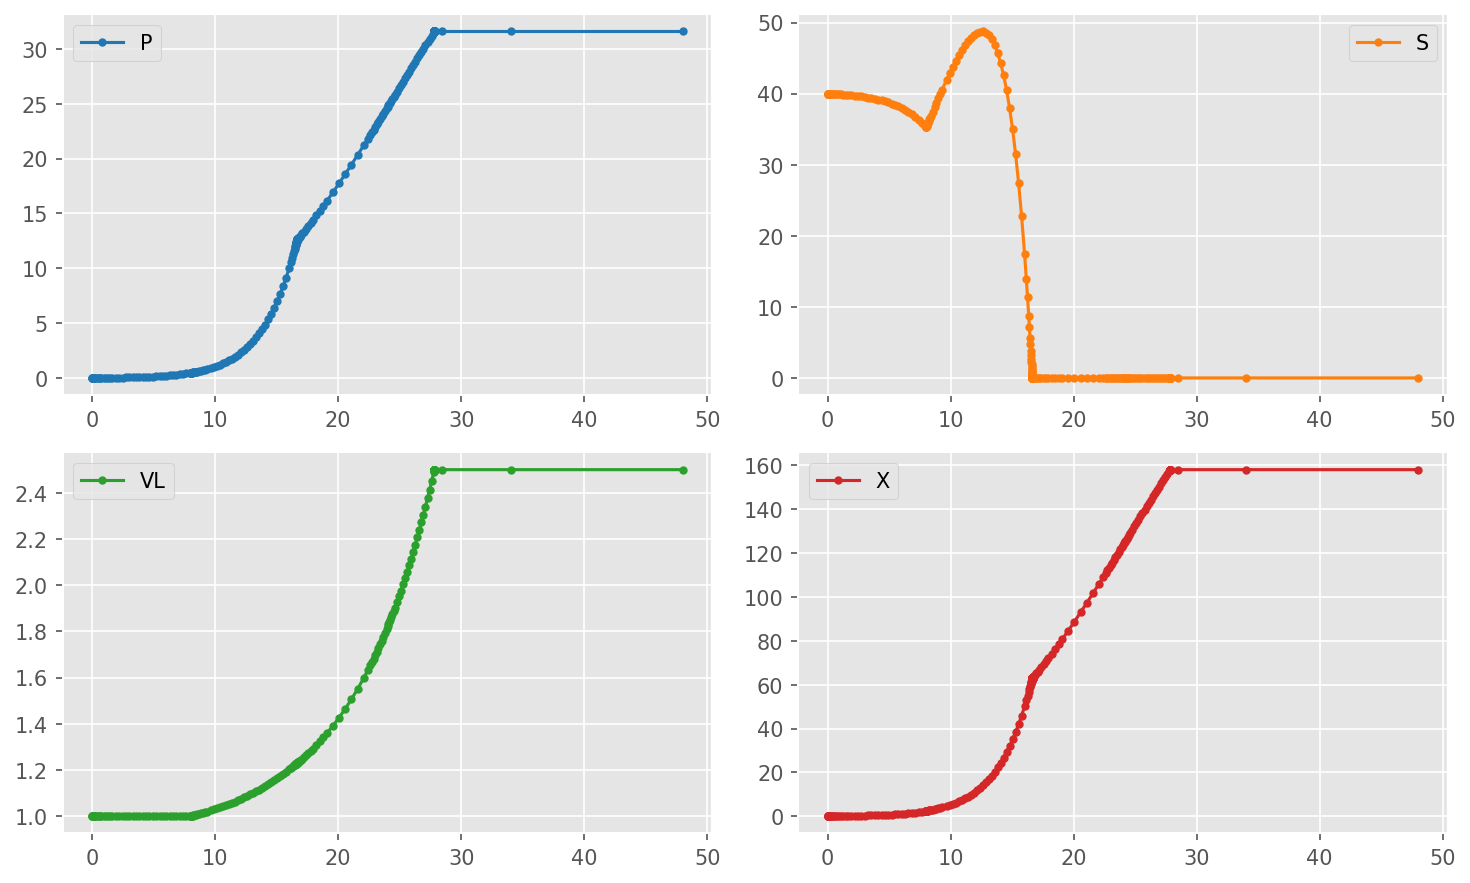

In [3]:
simulation = caretaker.simulate(t=48)
_ = Visualization.show_kinetic_data(simulation, ncols=2)

# 2. Fed-batch example

Implements another variant of the fed-batch process with a parametrized feeding profile that is calculated in an own method, demonstrating the great power of object oriented programming. This approach ensures that the property `model_parameters` is accessible from this method, omitting the need of have the feeding profile parameters as method arguments.

The feeding profile is described by a linear equation, with tow additional parameters that describe two points in time at which the constant and linear term of the feeding profile are activated. 


In [4]:
# Defines the model class
class ParametrizedFedBatch(BioprocessModel):

    def rhs(self, t, y, sw):
        
        # Unpacks the state vector. The states are alphabetically ordered.
        P, S, VL, X = y
        
        # Unpacks the model parameters.
        cSF = self.model_parameters['cSF']
        
        # Calculate the current growth rate
        mu = self.growth_rate(y)
        
        # Calculate the current cell specific catabolite repressed productivity
        qP = self.catabolite_repression_qP(y)
        
        # Calculate the current cell specific substrate consumption rate
        qS = self.substrate_consumption(y, mu, qP)
        
        # Calculate the feeding profile, conditional to the corresponding events
        F = self.feeding_profile(t, sw)
        
        # Calculate state derivatives
        dXdt = mu * X - F/VL * X
        dSdt = -qS * X + F/VL * (cSF - S)
        dPdt = qP * X - F/VL * P
        dVLdt = F
        
        # Return list of state derivatives in the same order as the state vector was unpacked
        return [dPdt, dSdt, dVLdt, dXdt]
    
    
    def state_events(self, t, y, sw):
        
        P, S, VL, X = y
        VL_max = self.model_parameters['VL_max']
        # The event is hit, when this expression evaluates to zero
        event_VL_max = VL - VL_max
        
        tF = self.model_parameters['tF']
        # The event is hit, when this expression evaluates to zero
        event_tF = t - tF
        
        return [event_VL_max, event_tF]
    
    
    # Monod equation with the growth-inhibiting product concentration
    def growth_rate(self, y):
        P, S, VL, X = y
        mu_max = self.model_parameters['mu_max']
        kS = self.model_parameters['kS']
        kPI = self.model_parameters['kPI']
        mu = mu_max * S / (kS + S) * P / (P + kPI)
        return mu
    
    
    # Cell specific substrate consumption
    def substrate_consumption(self, y, *args):
        P, S, VL, X = y
        mu, qP = args
        YXS = self.model_parameters['YXS']
        YPS = self.model_parameters['YPS']
        qS = mu/YXS + qP/YPS
        
        return mu/YXS + qP/YPS
    
    
    # Cell specific catabolite repressed productivity, modelled as substrate inhibition
    def catabolite_repression_qP(self, y):
        P, S, VL, X = y
        kSPI = self.model_parameters['kSPI']
        qP_max = self.model_parameters['qP_max']
        kSP = self.model_parameters['kSP']
        qP = qP_max * S / (kSP + S + S**2/kSPI)
        return qP
    
    
    # Calculation of feeding profile
    def feeding_profile(self, t, sw):
        if sw[1]:
            F = self.model_parameters['F_set']
        else:
            F = 0.0
        # The first switch is active when the maximum allowed volume is reached
        if sw[0]:
            F = 0.0
        return F
    
    
model_parameters = {
    'kS' : 0.5,
    'kSP' : 0.1,
    'kSPI' : 0.5,
    'kPI' : 0.01,
    'mu_max' : 0.4,
    'YXS' : 0.55,
    'YPS' : 0.2,
    'qP_max' : 0.6,
    'cSF' : 500.0,
    'F_set' : 0.04,
    'tF' : 5.0,
    'VL_max' : 2.5,
}     

initial_values = {
    'S0' : 40.0,
    'X0' : 1.0,
    'P0' : 0.0,
    'VL0' : 1.0,
}

        
caretaker = Caretaker(
    bioprocess_model_class=ParametrizedFedBatch, 
    model_parameters=model_parameters, 
    initial_values=initial_values,
)

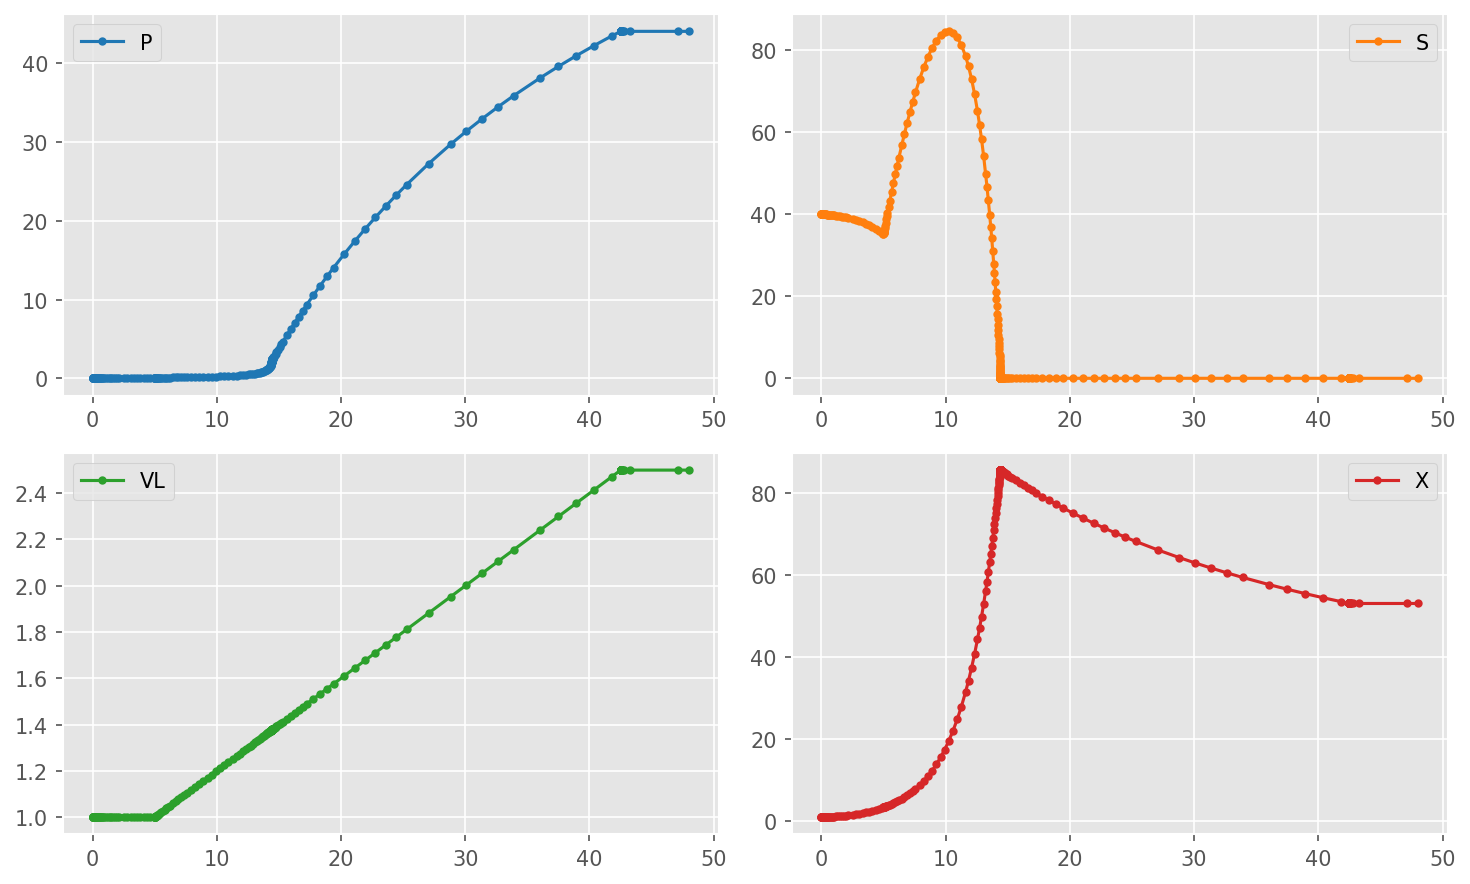

In [5]:
tfinal = 48.0
simulation = caretaker.simulate(t=tfinal)
_ = Visualization.show_kinetic_data(simulation, ncols=2)

## 2.1. Calculate trajectories for product mass and Space-Time-Yield

From the obtained trajectories of the model states, we will derive further `TimeSeries` object, namely the time course of  product mass (remember the changing volume in a fed-batch process) and corresponding Space-Time-Yield.

In [6]:
def calculate_additional_timeseries(simulation:list):

    t = Helpers.extract_time_series(simulation, name='S', replicate_id=None).timepoints
    VL = Helpers.extract_time_series(simulation, name='VL', replicate_id=None).values
    P = Helpers.extract_time_series(simulation, name='P', replicate_id=None).values

    _P_mass = P * VL
    P_mass = TimeSeries(name='P_mass', timepoints=t, values=_P_mass)

    _STY = _P_mass[1:] / t[1:] # To avoid a ZeroDivisionError
    STY = TimeSeries(name='STY', timepoints=t[1:], values=_STY)
    
    STY_max = numpy.max(_STY[1:])
    P_mass_max = numpy.max(_P_mass)
    
    return STY_max, P_mass_max, [P_mass, STY]

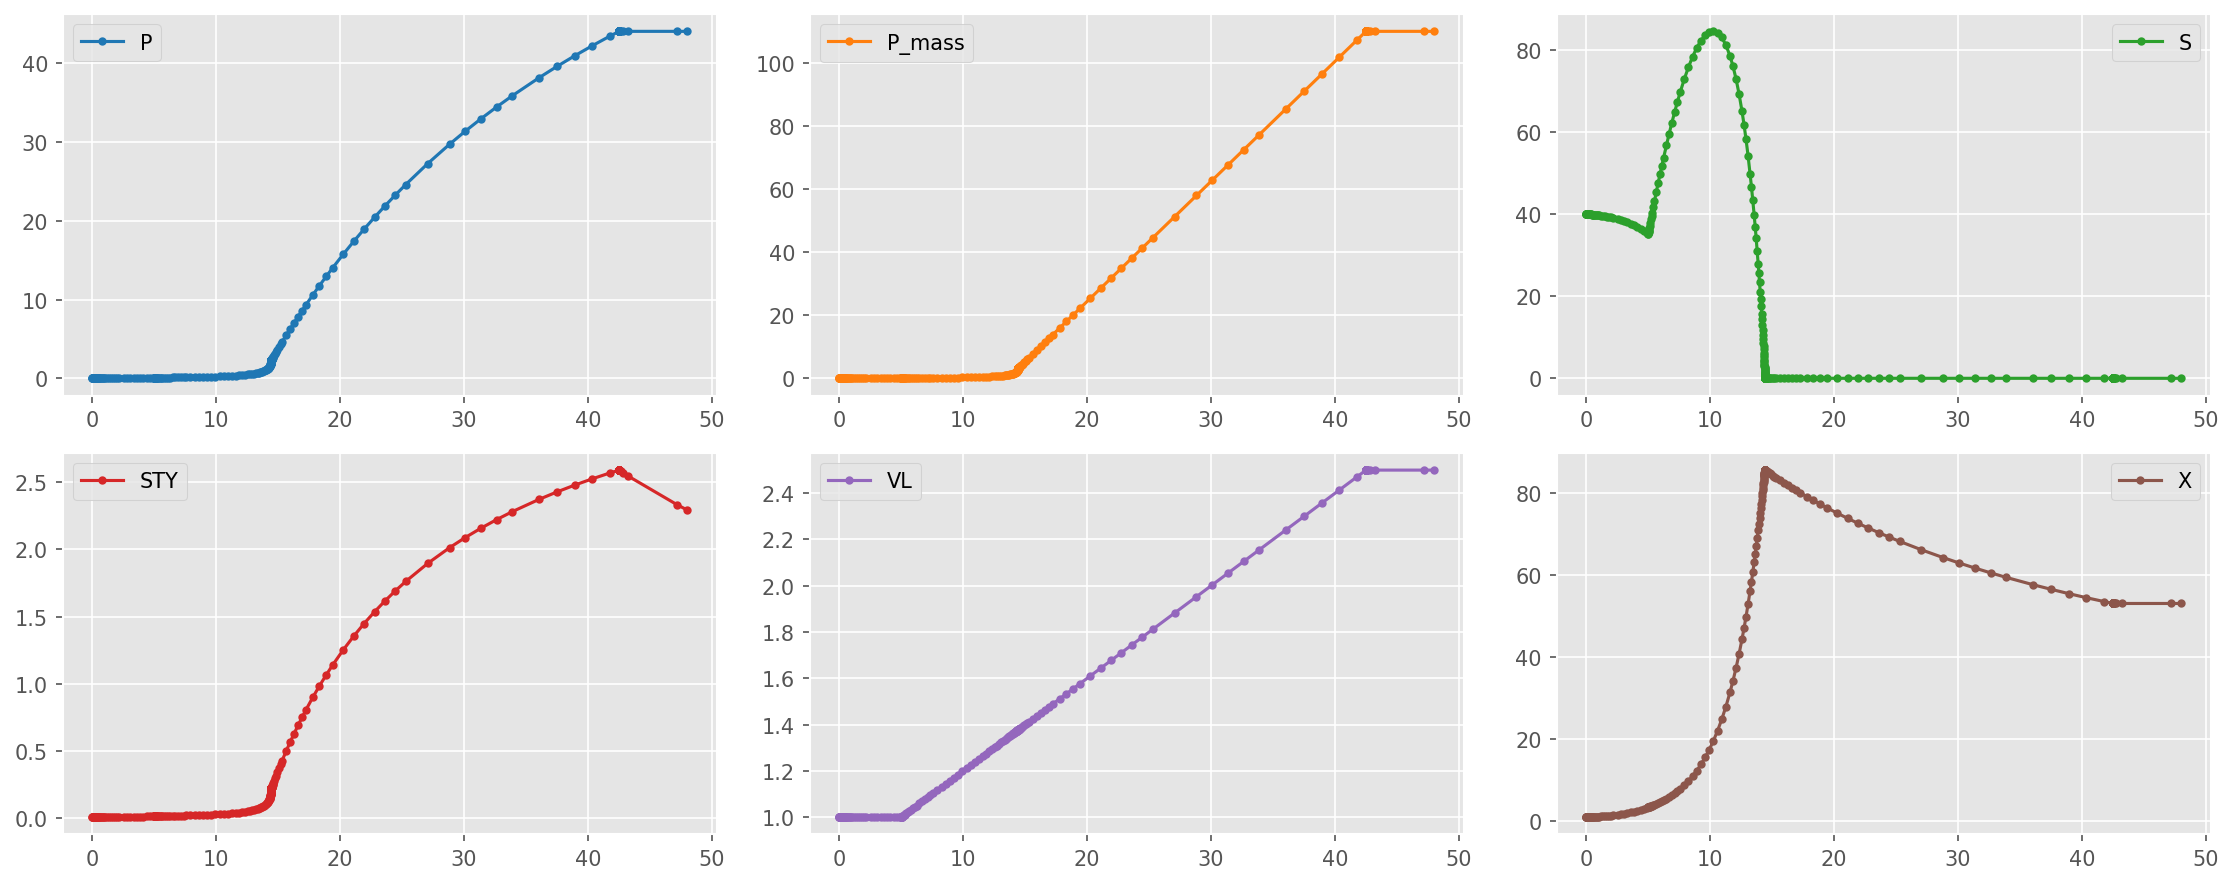

In [7]:
_, _, additional_timeseries = calculate_additional_timeseries(simulation)
simulation.extend(additional_timeseries)
_ = Visualization.show_kinetic_data(simulation)

## 2.2. Adjusting parameter `F_set` to optimize product mass and Space-Time-Yield 
Typically, a fed-batch process is used to optimize some objective, e.g. to maximize the amount of product or the corresponding space-time-yield. Let's vary the parameter `F_set` to see its impact on these two objectives.

In [8]:
F_set = numpy.linspace(0.001, 0.1, 100)

STY_max = []
P_mass_max = []

for _F_set in F_set:
    with io.capture_output() as captured:
        _simulation = caretaker.simulate(t=tfinal, parameters={'F_set' : _F_set})
    _STY_max, _P_mass_max, _ = calculate_additional_timeseries(_simulation)
    STY_max.append(_STY_max)
    P_mass_max.append(_P_mass_max)

STY_max = numpy.array(STY_max)
P_mass_max = numpy.array(P_mass_max)

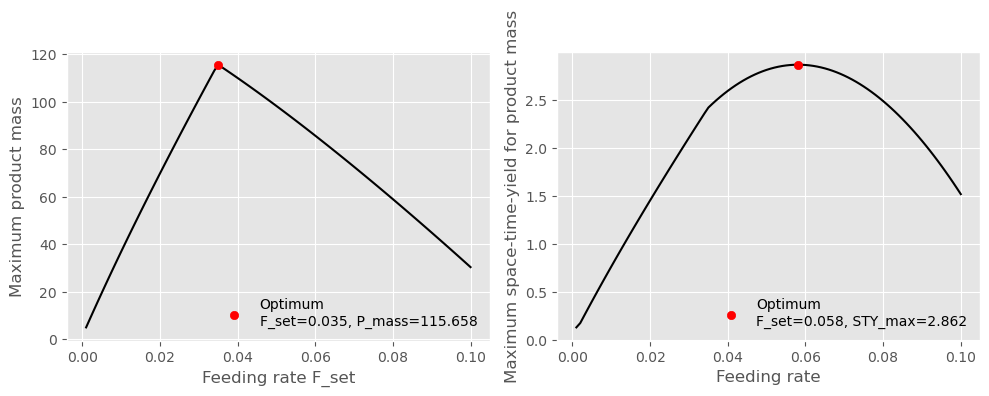

In [9]:
fig, ax = pyplot.subplots(nrows=1, ncols=2, figsize=(10, 4), dpi=100)
ax[0].plot(F_set, P_mass_max, color='black', zorder=1)
_max_idx = numpy.argmax(P_mass_max)
_x = F_set[_max_idx]
_y = P_mass_max[_max_idx]
ax[0].scatter(_x, _y, color='red', zorder=2, label=f'Optimum\nF_set={_x:.3f}, P_mass={_y:.3f}')
ax[0].set_ylabel('Maximum product mass')
ax[0].set_xlabel('Feeding rate F_set')
ax[0].legend(frameon=False)
ax[1].plot(F_set, STY_max, color='black', zorder=1)
_max_idx = numpy.argmax(STY_max)
_x = F_set[_max_idx]
_y = STY_max[_max_idx]
ax[1].scatter(_x, _y, color='red', zorder=2, label=f'Optimum\nF_set={_x:.3f}, STY_max={_y:.3f}')
ax[1].set_ylabel('Maximum space-time-yield for product mass')
ax[1].set_xlabel('Feeding rate')
ax[1].legend(frameon=False)
fig.tight_layout()

# 3. Fed-batch example

Implements the fed-batch process with another, parametrized feeding profile.

The corresponding model class inherits from the previous one, since only the method for calculating the feeding profile, as well as the method defining the state events will differ. This highlights the usefulnes of the object oriented approach. 

In [10]:
class ParametrizedFedBatchV2(ParametrizedFedBatch):
    
    def state_events(self, t, y, sw):
        P, S, VL, X = y
        
        VL_max = self.model_parameters['VL_max']
        event_VL_max = VL - VL_max
        
        tF1 = self.model_parameters['tF1']
        event_tF1 = t - tF1
        
        tF2 = self.model_parameters['tF2']
        event_tF2 = t - tF2
        return [event_VL_max, event_tF1, event_tF2]
    
    
    def feeding_profile(self, t, sw):
        
        # Calculate first term of feeding profile
        if sw[1]:
            F_constant = self.model_parameters['F_constant']
        else:
            F_constant = 0.0
        
        # Calculate second term of feeding profile
        if sw[2]:
            F_linear = self.model_parameters['F_linear'] 
            tF1 = self.model_parameters['tF1'] 
            t_feed = t - tF1
            F1 = F_linear * t_feed
        else:
            F1 = 0.0
            
        # Calculate current feeding rate
        F = F_constant + F1
        
        if sw[0]:
            F = 0.0
        return F
    
    
model_parameters = {
    'kS' : 0.5,
    'kSP' : 0.1,
    'kSPI' : 0.5,
    'kPI' : 0.01,
    'mu_max' : 0.4,
    'YXS' : 0.55,
    'YPS' : 0.2,
    'qP_max' : 0.6,
    'cSF' : 500.0,
    'F_constant' : 0.2,
    'F_linear' : 0.05,
    'VL_max' : 2.5,
    'tF1' : 5.0,
    'tF2' : 10.0,
}     

initial_values = {
    'S0' : 10.0,
    'X0' : 1.0,
    'P0' : 0.0,
    'VL0' : 1.0,
}

        
caretaker = Caretaker(
    bioprocess_model_class=ParametrizedFedBatchV2, 
    model_parameters=model_parameters, 
    initial_values=initial_values,
)

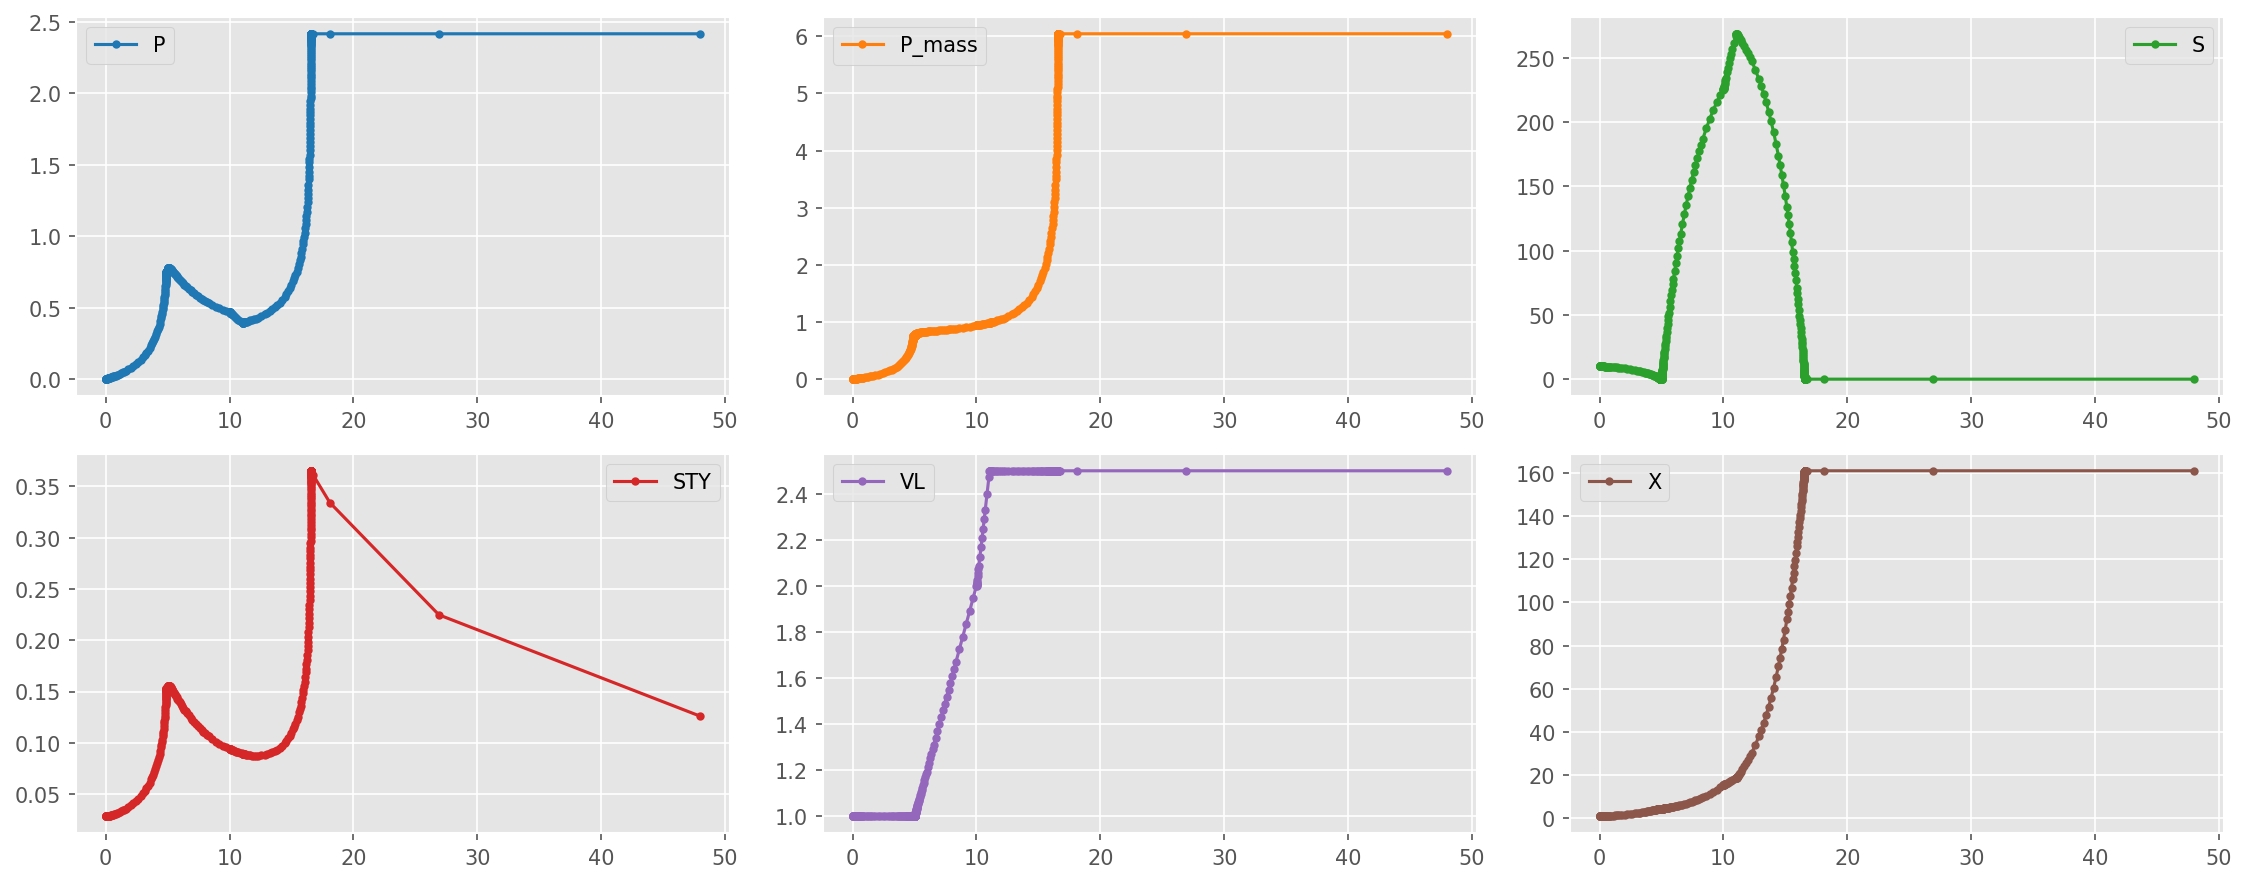

In [11]:
simulation = caretaker.simulate(t=tfinal)
_, _, additional_timeseries = calculate_additional_timeseries(simulation)
simulation.extend(additional_timeseries)
_ = Visualization.show_kinetic_data(simulation)

## 3.1. Determination of optimal feeding profile parameters (Optimal Control Problem)

Now consider that we can define an objective that shall be maximized or minimized.
More specifically, the amount of product (`P_mass`) shall be maximized by choosing a corresponding optimal values for a set of process parameters. Here, we want to optimize the feeding profile parameters. 

For the optimization task, we will use the `pygmo` package, which provides massively parallel optimization routines via the Generalized Island Model. For further information, please refer to the excellent documentation at https://esa.github.io/pagmo2/. In short, an optimization problem class has to be implemented, which is then used to create a problem instance. The parallelization is realized by the creation of several optimizer instances (referred to as islands), which harbor populations that are evolved (i.e., optimized) by a certain algorithm, in our case Self-Adaptive Differential Evolution. After evolving a specified number of generations, the different islands can exchange individuals of their populations according to specified heuristics, for another round of evolution.

In [12]:
n_cpus = multiprocessing.cpu_count()
print(f'Current {pygmo.__name__} version: {pygmo.__version__}')

Current pygmo version: 2.14.0


### 3.1.1. Implementation of the specific problem class

This class must implement two mandatory methods, namely `fitness` and `get_bounds`. Please refer also to the `pygmo` documentation. 

For our specific problem, we want the value of parameter `tF1` not be greater that the value of parameter `tF2`. This constraint is easily implemented by checking this condition in the `fitness` method and returning a very high penality as fitness value for this case.

In addition, the optimizer may choose a "toxic" combination of parameter values which cause integration errors. This situation is handled via a `try` - `catch` clause, returning also a very high penality as fitness value.

In [13]:
class OptimizationProblem():
    """
    Defines a class with mandatory methods needed for optimization,
    using the pygmo package implementing the generalized islands model.
    """
    
    def __init__(self, unknowns:list, bounds:list, tfinal:float, caretaker:Caretaker, target:str):
        self.unknowns = unknowns
        self.lower_bounds = [_bounds[0] for _bounds in bounds]
        self.upper_bounds = [_bounds[1] for _bounds in bounds]
        self.tfinal = tfinal
        self.caretaker = caretaker
        self.target = target

        
    def fitness(self, x):
        
        # Create current parameter dictionary
        parameters = {_name: _x for _name, _x in zip(self.unknowns, x)}
        
        # Run  a forward simulation for the current parameter values
        try:
            simulation = self.caretaker.simulate(t=self.tfinal, parameters=parameters)
            STY_max, P_mass_max, _ = calculate_additional_timeseries(simulation)
            # Assign specified optimization target
            if self.target == 'STY_max':
                obj = -1*STY_max
            elif self.target == 'P_mass_max':
                obj = -1*P_mass_max
                
        # Toxic (combination of) parameter values cause integration errors
        except CVodeError:
            print(f'\n\nApparently toxic parameters:\n{parameters}')
            obj = numpy.inf
            
        # Violation of this constraint is strongly penalized
        if parameters['tF1'] > parameters['tF2']:
            obj = numpy.inf  
            
        # Must return an array-like variable.
        return [obj]
    
    
    def get_bounds(self):
        return (self.lower_bounds, self.upper_bounds)
    
    
    @staticmethod
    def extract_results(unknowns, archipelago):
        """
        A static convenience method that extracts the optimized results for making nice output
        """
        
        estimates_info = {}
        best_idx = numpy.argmin(numpy.array(archipelago.get_champions_f()).flatten())
        best_estimates = {
            _unknown : _x 
            for _unknown, _x in zip(unknowns, archipelago[int(best_idx)].get_population().champion_x)
        }
        best_objective = archipelago[int(best_idx)].get_population().champion_f
        return best_estimates, best_objective

### 3.1.2. Find optimal feeding profile parameters to maximize amount of product 

In [14]:
# Defines which parameters shall be optimized, as well as their corresponding bounds
unknowns = ['F_constant', 'F_linear', 'tF1', 'tF2']
bounds = [(0.0, 0.1), (0.0, 0.1), (0.0, tfinal), (0.0, tfinal)]

# Creates an instance of `OptimizationProblem`, needed for the archipelago creation
opt_problem = pygmo.problem(
    OptimizationProblem(
        unknowns=unknowns, 
        bounds=bounds, 
        tfinal=tfinal, 
        caretaker=caretaker, 
        target='P_mass_max',
    )
)

The next cell creates the `archipelago` object, which will provide the convenient methods for optimization. There are several ways to create such archipelago, e.g. a different optimization algorithm can be used for each island of the archipelago, or different topologies and rules for exchange of individuals can be employed. Please refer to the `pygmo` documentation for further information.

In [15]:
# Create the archipelago
# NOTE: May take some time since this process is (here) not parallelized for simplicity
with io.capture_output() as captured:
    archi = pygmo.archipelago(
        n=n_cpus, 
        algo=pygmo.de1220(gen=10),
        prob=opt_problem, 
        pop_size=5*len(unknowns), 
        t=pygmo.ring(), # could also be: pygmo.fully_connected()
        udi=pygmo.mp_island(),
    )
archi.wait_check()

In [16]:
# Run a few rounds of evolution, and report intermediate objective values, as well as the finally optimized parameters
evolutions = 10
for i in range(evolutions):
    archi.evolve()
    archi.wait_check()
    best_estimates, best_objective = OptimizationProblem.extract_results(unknowns, archi)
    print(f'Optimal product mass after {i+1} evolutions: {-1*best_objective[0]}')

print('\nOptimal parameter values\n--------------------------')
for _p in best_estimates:
    print(f'{_p} : {best_estimates[_p]}')

Optimal product mass after 1 evolutions: 134.63109053439993
Optimal product mass after 2 evolutions: 136.7881135101606
Optimal product mass after 3 evolutions: 139.21261723039174
Optimal product mass after 4 evolutions: 140.57331301807585
Optimal product mass after 5 evolutions: 140.57331301807585
Optimal product mass after 6 evolutions: 140.57331301807585
Optimal product mass after 7 evolutions: 140.6609547849766
Optimal product mass after 8 evolutions: 140.70947481534978
Optimal product mass after 9 evolutions: 140.72948500293796
Optimal product mass after 10 evolutions: 140.7319330951799

Optimal parameter values
--------------------------
F_constant : 0.015730606373628945
F_linear : 0.00089272482719203
tF1 : 4.86898675389549
tF2 : 8.072729777986016


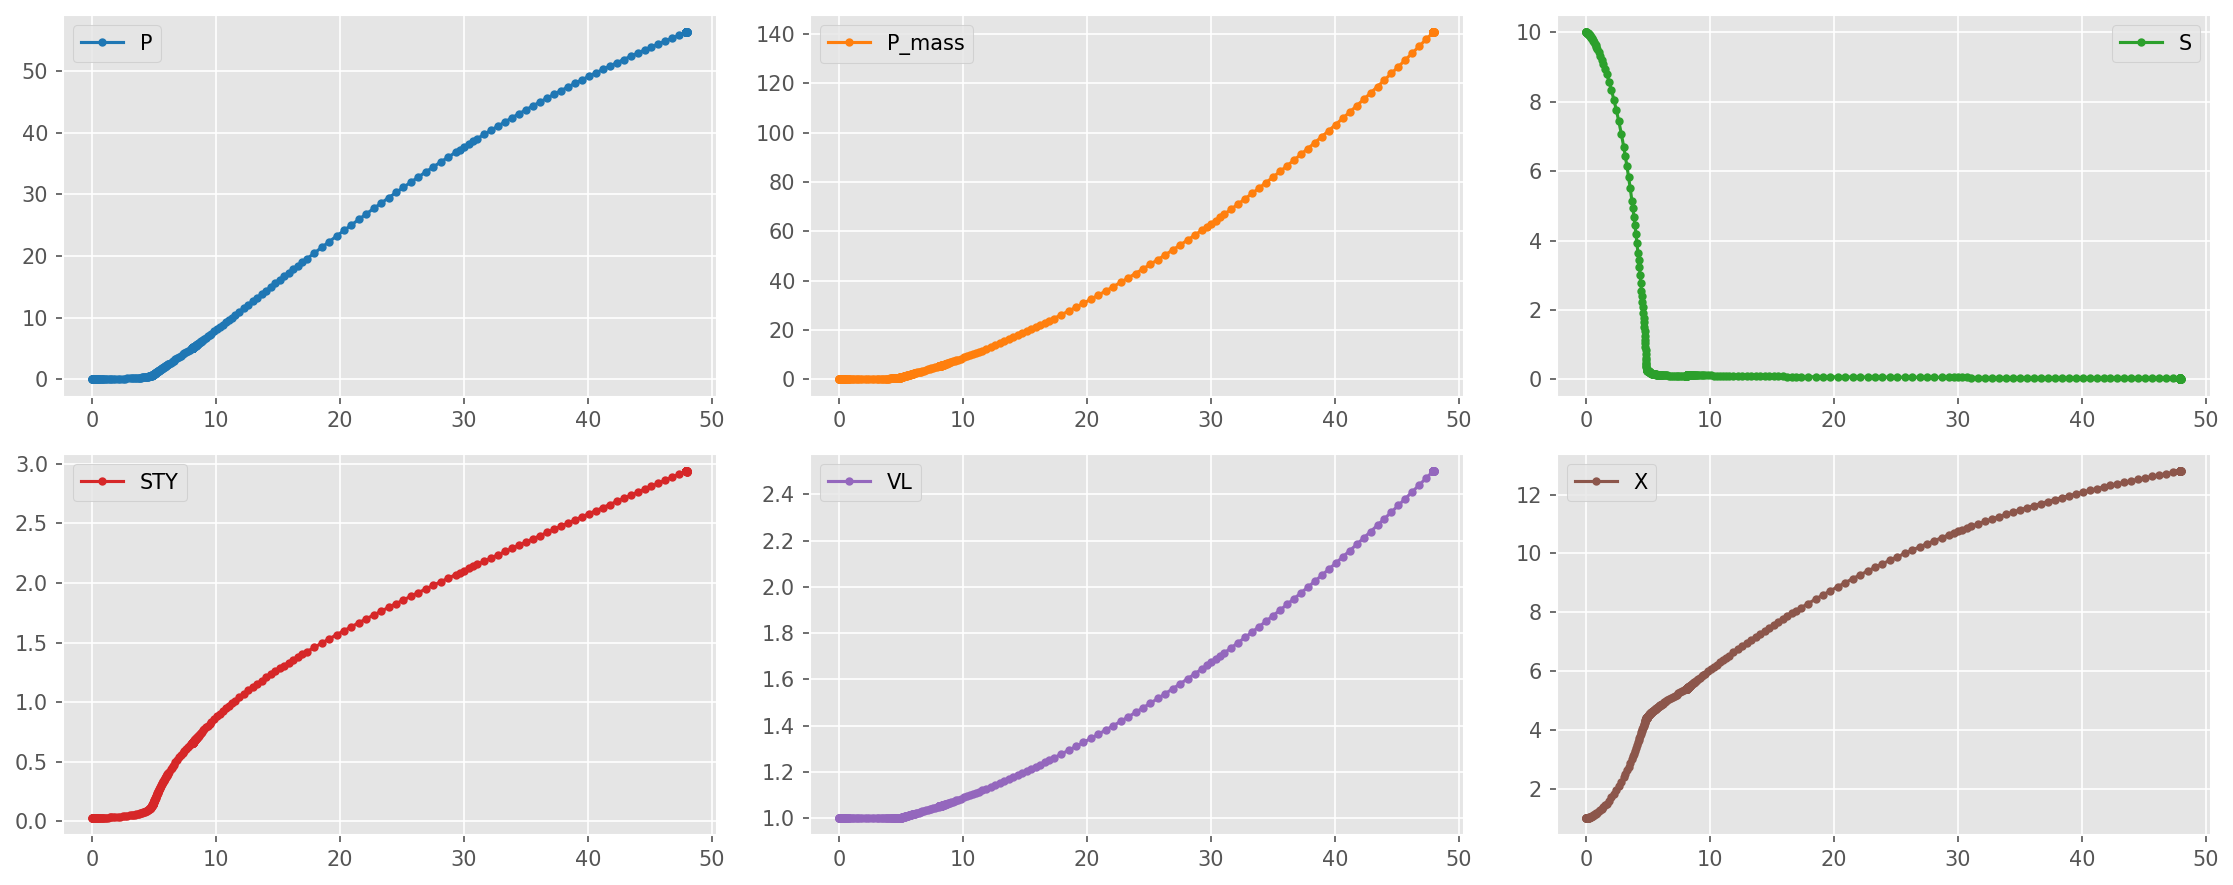

In [17]:
# Show the resulting trajectories
simulation = caretaker.simulate(t=tfinal, parameters=best_estimates)
_, _, additional_timeseries = calculate_additional_timeseries(simulation)
simulation.extend(additional_timeseries)
_ = Visualization.show_kinetic_data(simulation)

Because the archipelago updates its state after each evolution, we can just continue evolving.

In [18]:
# Run another round of evolutions and see the results
evolutions = 5
for i in range(evolutions):
    archi.evolve()
    archi.wait_check()
    best_estimates, best_objective = OptimizationProblem.extract_results(unknowns, archi)
    print(f'Optimal product mass after {i+1} evolutions: {-1*best_objective[0]}')

print('\nOptimal parameter values\n--------------------------')
for _p in best_estimates:
    print(f'{_p} : {best_estimates[_p]}')

Optimal product mass after 1 evolutions: 140.74270095200393
Optimal product mass after 2 evolutions: 140.74531679489485
Optimal product mass after 3 evolutions: 140.746068367392
Optimal product mass after 4 evolutions: 140.7463957061379
Optimal product mass after 5 evolutions: 140.74653804968455

Optimal parameter values
--------------------------
F_constant : 0.016291494485771323
F_linear : 0.0008602791859124591
tF1 : 4.879472291761654
tF2 : 6.860638683316177


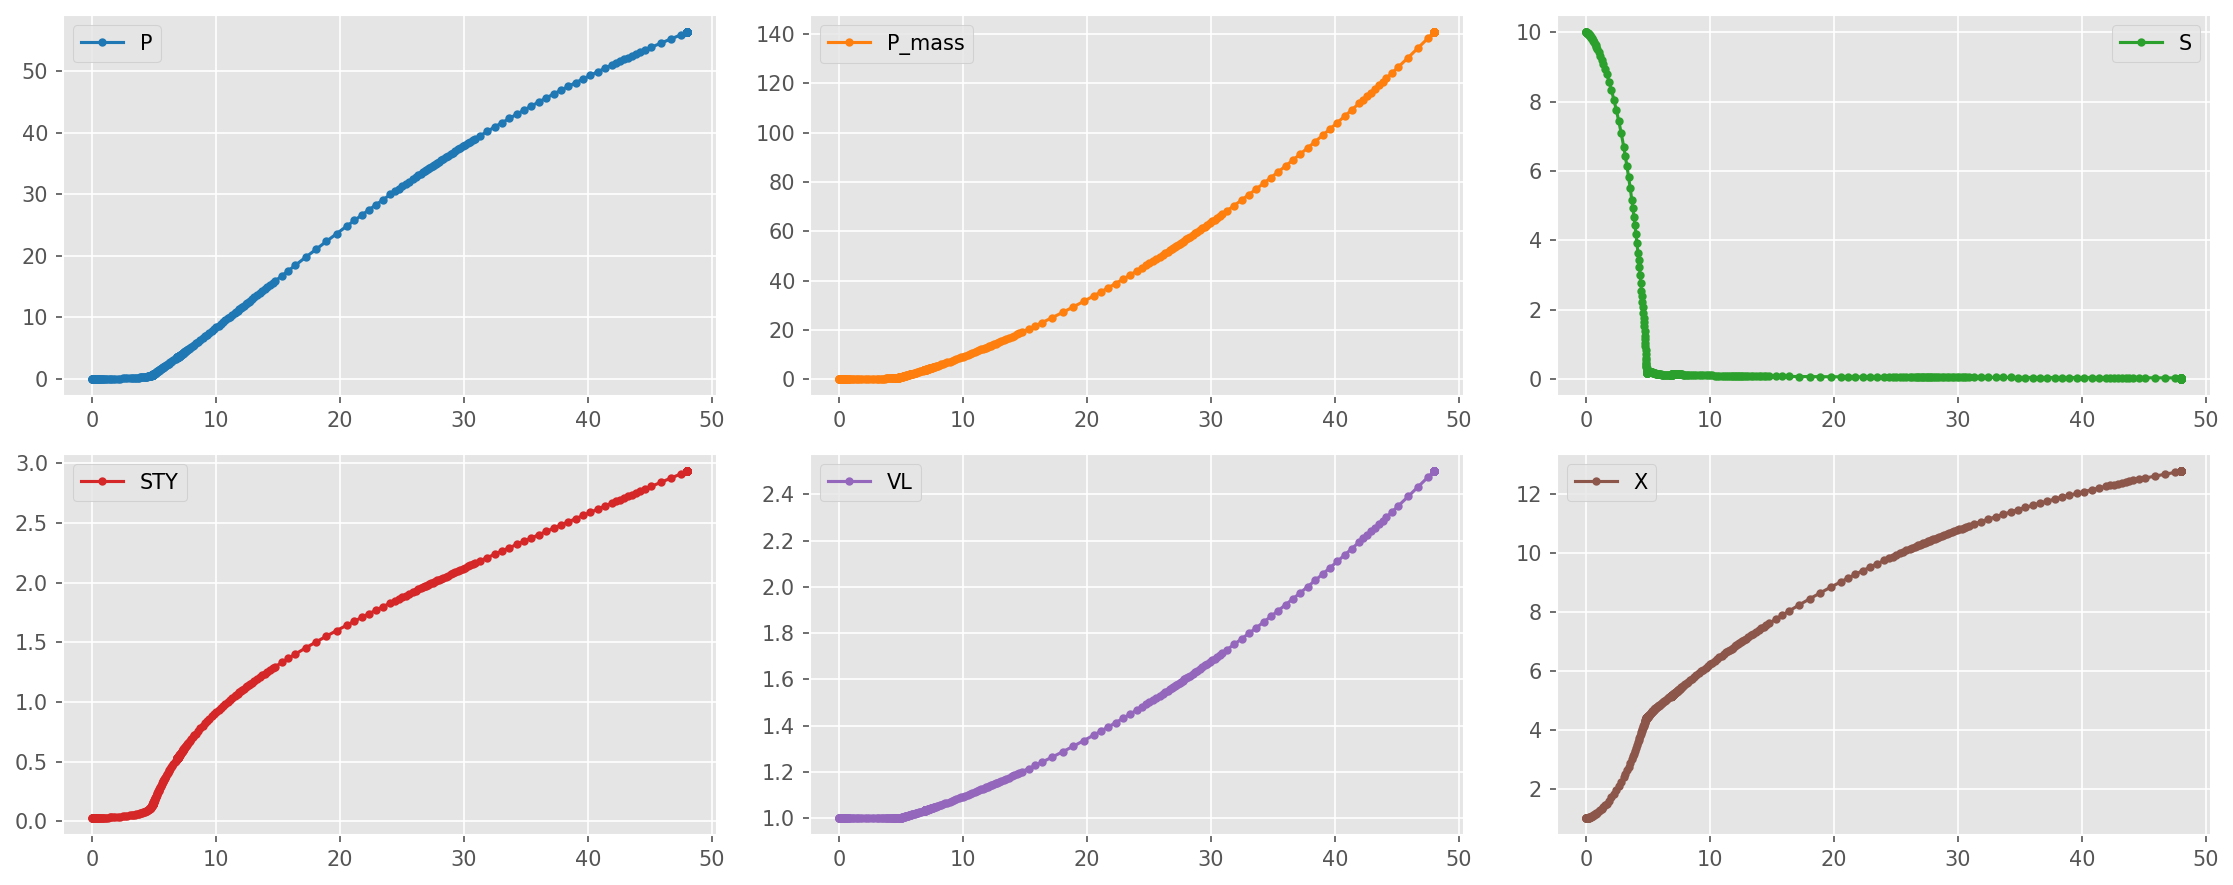

In [19]:
# Show the resulting trajectories
simulation = caretaker.simulate(t=tfinal, parameters=best_estimates)
_, _, additional_timeseries = calculate_additional_timeseries(simulation)
simulation.extend(additional_timeseries)
_ = Visualization.show_kinetic_data(simulation)

### 3.1.3. Find optimal feeding profile parameters to maximize Space-Time-Yield

In [20]:
# Create a new instance of the `OptimizationProblem`, but with the other target `STY_max`
opt_problem = pygmo.problem(
    OptimizationProblem(
        unknowns=unknowns, 
        bounds=bounds, 
        tfinal=tfinal, 
        caretaker=caretaker, 
        target='STY_max',
    )
)

In [21]:
# Create the archipelago
with io.capture_output() as captured:
    archi = pygmo.archipelago(
        n=n_cpus, 
        algo=pygmo.de1220(gen=10),
        prob=opt_problem, 
        pop_size=5*len(unknowns), 
        t=pygmo.ring(), # could also be: pygmo.fully_connected()
        udi=pygmo.mp_island(),
    )
    
archi.wait_check()

In [22]:
evolutions = 15
for i in range(evolutions):
    archi.evolve()
    archi.wait_check()
    best_estimates, best_objective = OptimizationProblem.extract_results(unknowns, archi)
    print(f'Optimal Space-Time-Yield after {i+1} evolutions: {-1*best_objective[0]}')

print('\nOptimal parameter values\n--------------------------')
for _p in best_estimates:
    print(f'{_p} : {best_estimates[_p]}')

Optimal Space-Time-Yield after 1 evolutions: 6.2057902481047105
Optimal Space-Time-Yield after 2 evolutions: 7.0924831100039345
Optimal Space-Time-Yield after 3 evolutions: 7.0924831100039345
Optimal Space-Time-Yield after 4 evolutions: 7.137752881873179
Optimal Space-Time-Yield after 5 evolutions: 7.187983474385385
Optimal Space-Time-Yield after 6 evolutions: 7.225124132353513
Optimal Space-Time-Yield after 7 evolutions: 7.23663600664645
Optimal Space-Time-Yield after 8 evolutions: 7.2611597815410285
Optimal Space-Time-Yield after 9 evolutions: 7.261770197905594
Optimal Space-Time-Yield after 10 evolutions: 7.261770197905594
Optimal Space-Time-Yield after 11 evolutions: 7.263208204136719
Optimal Space-Time-Yield after 12 evolutions: 7.263233875888601
Optimal Space-Time-Yield after 13 evolutions: 7.263800477112611
Optimal Space-Time-Yield after 14 evolutions: 7.263800477112611
Optimal Space-Time-Yield after 15 evolutions: 7.263855723021383

Optimal parameter values
--------------------

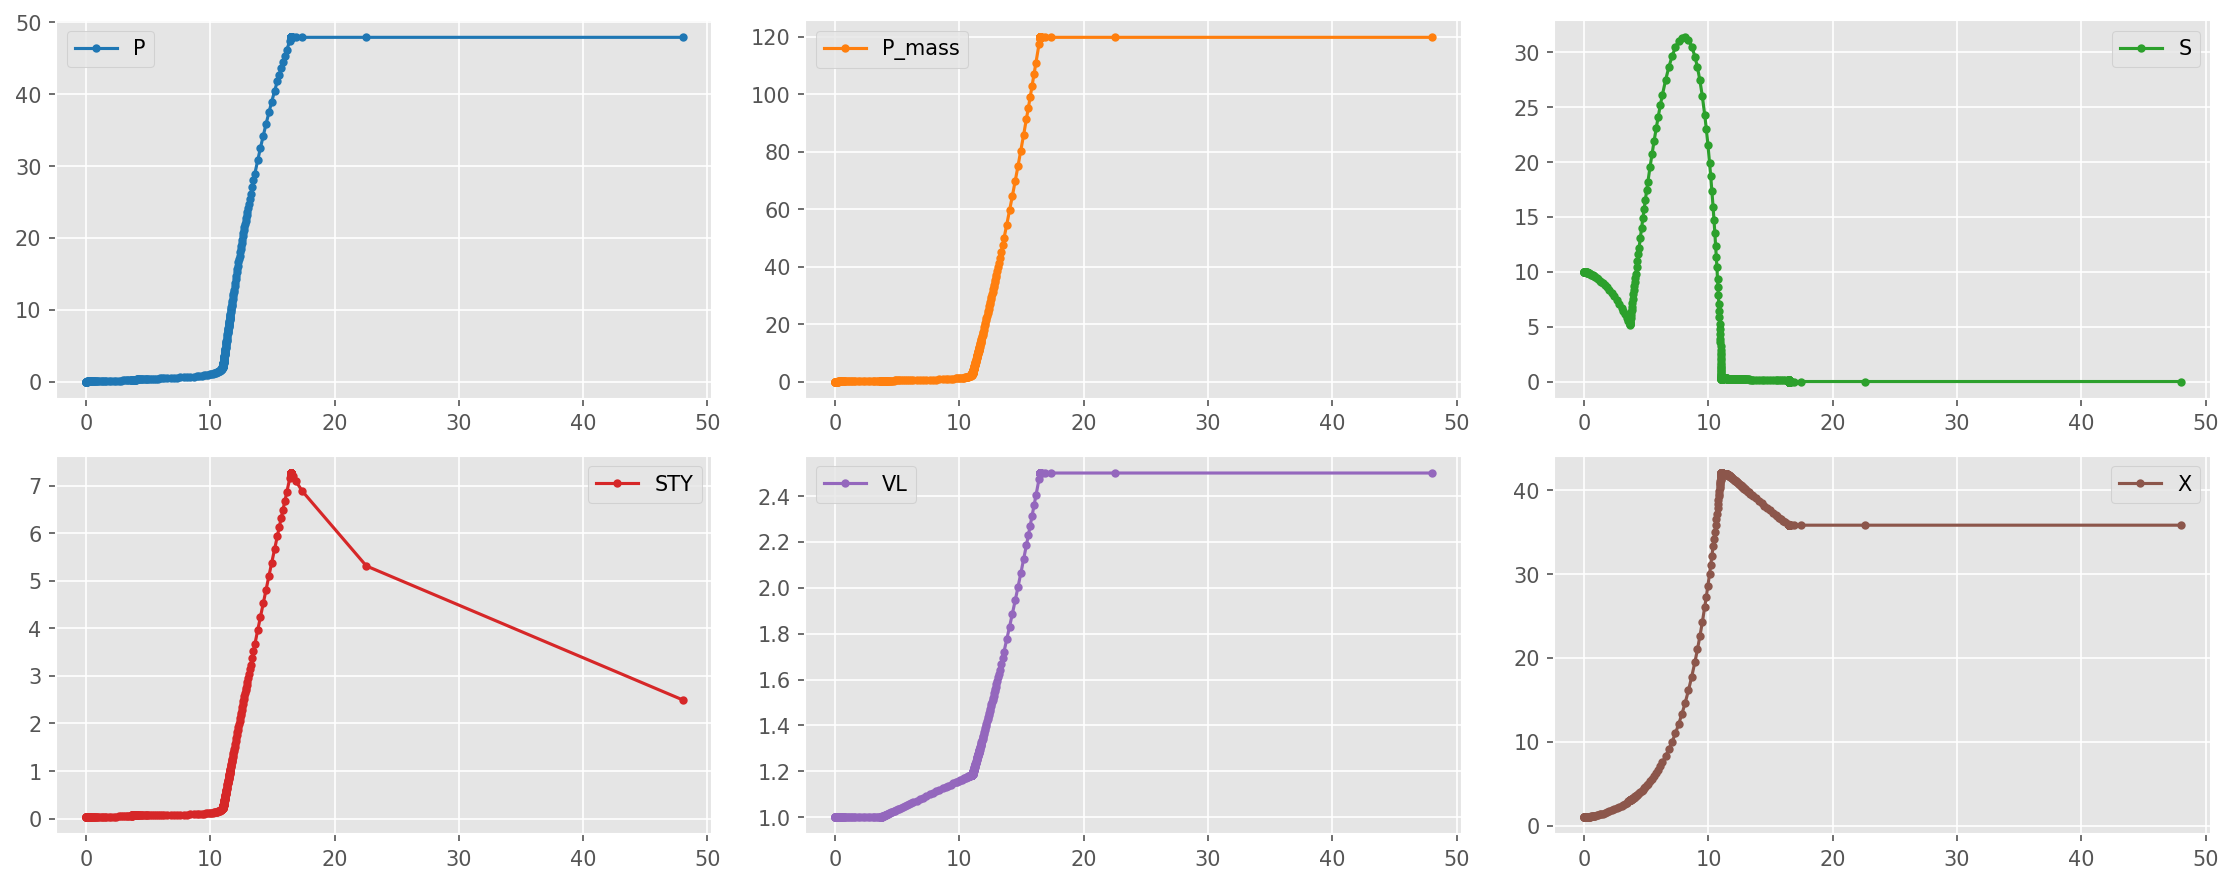

In [23]:
# Show the resulting trajectories
simulation = caretaker.simulate(t=tfinal, parameters=best_estimates)
_, _, additional_timeseries = calculate_additional_timeseries(simulation)
simulation.extend(additional_timeseries)
_ = Visualization.show_kinetic_data(simulation)

# 4. Fed-batch example

Implements another fed-batch process variant, with a feeding profile described by a 4<sup>th</sup> order polynomial that is activated at some timepoint. Once again, the great advantage of the object oriented principle of inheritance is seen when the new class `ParametrizedFedBatch_PolynomialFeed` subclasses the previous class `ParametrizedFedBatch`.

In [24]:
class ParametrizedFedBatch_PolynomialFeed(ParametrizedFedBatch):
    
    def feeding_profile(self, t, sw):
        
        # Calculate feeding profile
        if sw[1]:
            F0 = self.model_parameters['F0']
            F1 = self.model_parameters['F1']
            F2 = self.model_parameters['F2']
            F3 = self.model_parameters['F3']
            F4 = self.model_parameters['F4']
            tF = self.model_parameters['tF']
            F = F0 + F1*(t-tF) + F2*(t-tF)**2 + F3*(t-tF)**3 + F4*(t-tF)**4
        else:
            F = 0.0

        # Switch off feeding rate if maximum volume is reached
        if sw[0]:
            F = 0.0
        return F
    
    
    def state_events(self, t, y, sw):
        P, S, VL, X = y
        
        VL_max = self.model_parameters['VL_max']
        event_VL_max = VL - VL_max
        
        tF = self.model_parameters['tF']
        event_tF = t - tF
        
        return [event_VL_max, event_tF]
    
    
model_parameters = {
    'kS' : 0.5,
    'kSP' : 0.1,
    'kSPI' : 0.5,
    'kPI' : 0.01,
    'mu_max' : 0.4,
    'YXS' : 0.55,
    'YPS' : 0.2,
    'qP_max' : 0.6,
    'cSF' : 500.0,
    'VL_max' : 2.5,
    'tF' : 5.0,
    'F0' : 0.00005,
    'F1' : 0.00004,
    'F2' : 0.00002,
    'F3' : 0.00002,
    'F4' : 0.00002,
}     

initial_values = {
    'S0' : 10.0,
    'X0' : 1.0,
    'P0' : 0.0,
    'VL0' : 1.0,
}

        
caretaker = Caretaker(
    bioprocess_model_class=ParametrizedFedBatch_PolynomialFeed, 
    model_parameters=model_parameters, 
    initial_values=initial_values,
)

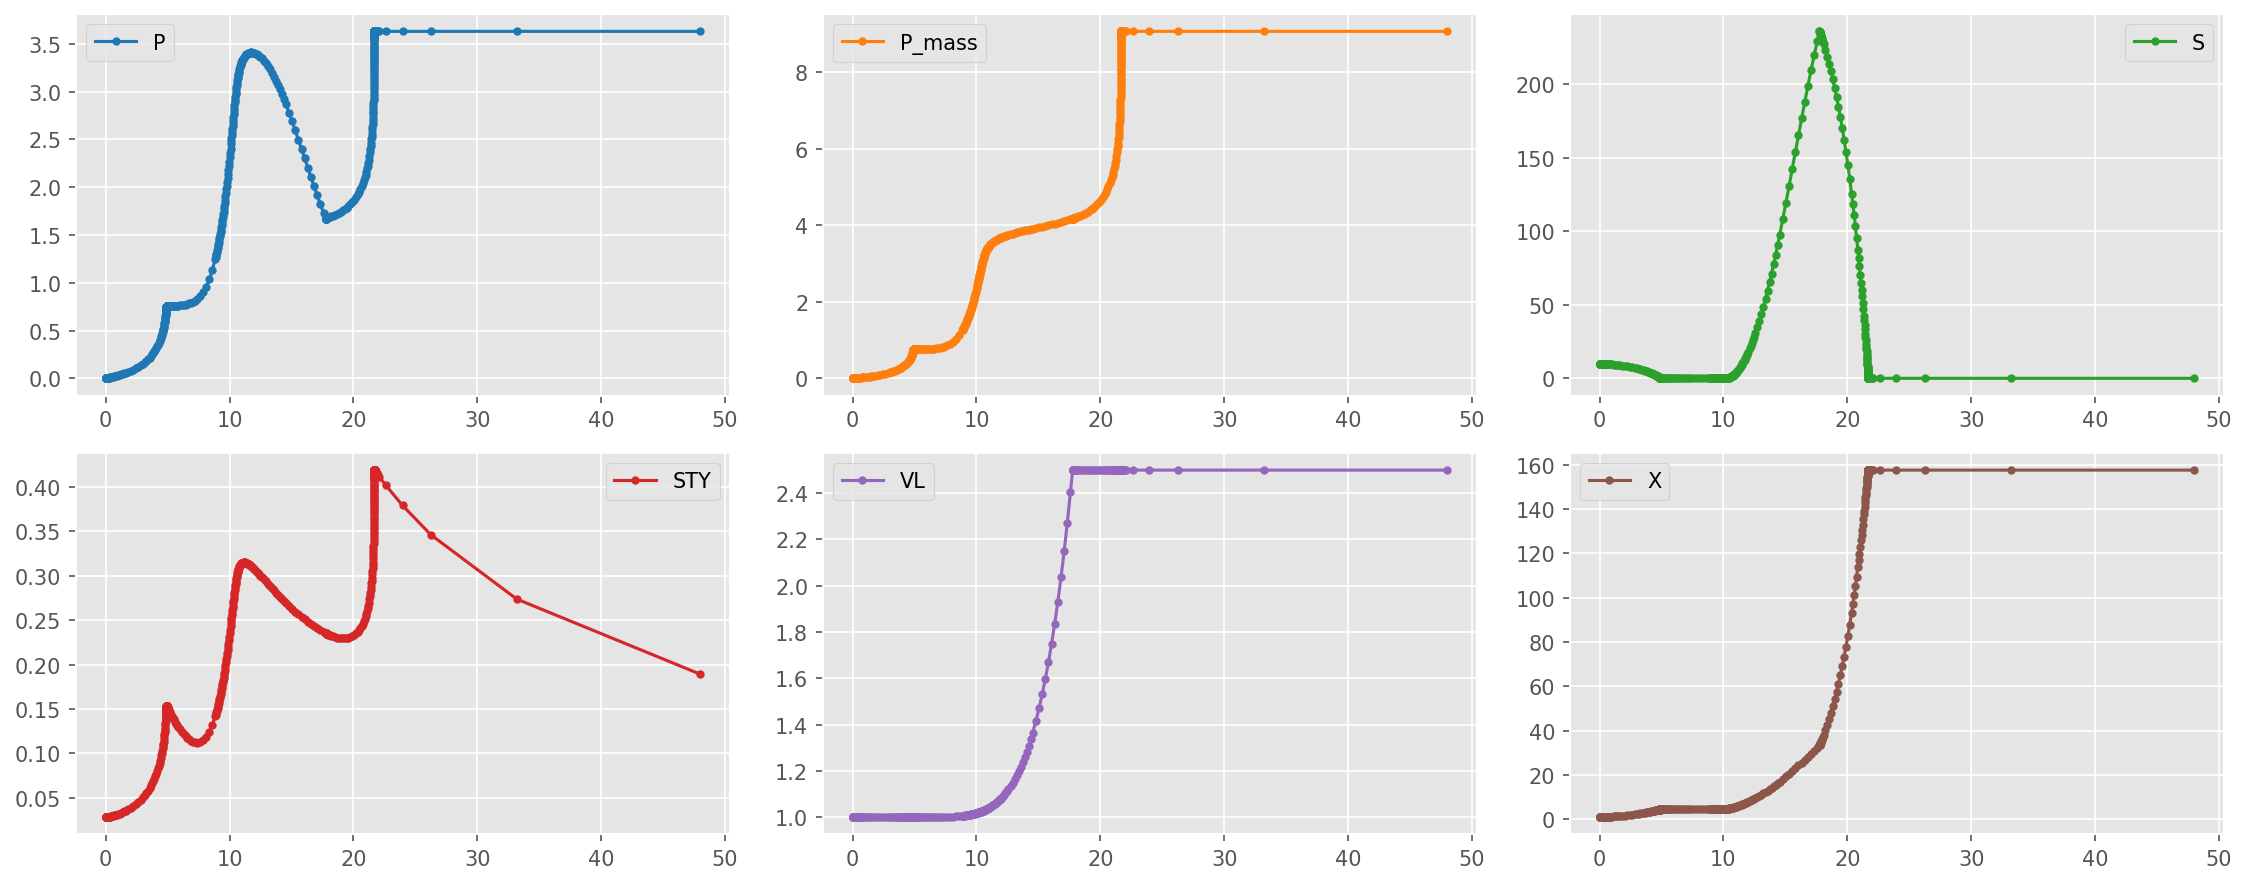

In [25]:
simulation = caretaker.simulate(t=tfinal)
_, _, additional_timeseries = calculate_additional_timeseries(simulation)
simulation.extend(additional_timeseries)
_ = Visualization.show_kinetic_data(simulation)

## 4.1. Feed parameter optimization

In [26]:
class OptimizationProblem_PolynomialFeed(OptimizationProblem):

    def fitness(self, x):
        
        # Create current parameter dictionary
        parameters = {_name: _x for _name, _x in zip(self.unknowns, x)}
        
        # Run  a forward simulation for the current parameter values
        try:
            simulation = self.caretaker.simulate(t=self.tfinal, parameters=parameters)
            STY_max, P_mass_max, _ = calculate_additional_timeseries(simulation)
            # Assign specified optimization target
            if self.target == 'STY_max':
                obj = -1*STY_max
            elif self.target == 'P_mass_max':
                obj = -1*P_mass_max
                
        # Toxic (combination of) parameter values cause integration errors
        except CVodeError:
            print(f'\n\nApparently toxic parameters:\n{parameters}')
            obj = numpy.inf
            
        # Must return an array-like variable.
        return [obj]

### 4.1.1. Maximization of product mass

In [27]:
# Defines which parameters shall be optimized, as well as their corresponding bounds
unknowns = ['tF', 'F0', 'F1', 'F2', 'F3', 'F4']
bounds = [(0.0, tfinal), (0.0, 0.1), (0.0, 0.1), (0.0, 0.1), (0.0, 0.1), (0.0, 0.1)]

# Create the instance of the new optimization problem
opt_problem = pygmo.problem(
    OptimizationProblem_PolynomialFeed(
        unknowns=unknowns, 
        bounds=bounds, 
        tfinal=tfinal, 
        caretaker=caretaker, 
        target='P_mass_max',
    )
)

This time, we will use different optimization algorithms in parallel. This approach can be useful, if the fitness landscape of the specific problem may be different for some algorithm. By emplyong the powerful Generalized Island Model for parallel optimization of the `pygmo` package, we can circumvent such situation. Therefore, it is important to run several evolutions, and define an archipelago topology that allows to exchange individuals between the islands after each evolution.

To implement this, a list of algorithm instances is created (`algos`). Next, a corresponding list `islands` is created, each instantiated with one of the algorithms. This step may take some time, because the creation of the islands population requires several fitness evaluations. Afterwards, an empty `archipelago` is instantiated, with the `fully_connected()` topology and each of the islands is added to the archipelago.

In [28]:
# Create the list of algorithm instances, the number of generations is increased to 15 for the corresponding algorithms
algos = [
    pygmo.de1220(gen=15),
    pygmo.pso(gen=15),
    pygmo.simulated_annealing(),
    pygmo.bee_colony(gen=15, limit=2),
]*int(numpy.ceil(n_cpus/4))

# Create the islands, each with the same problem, but different algorithms
with io.capture_output() as captured:
    islands = [
        pygmo.island(algo=_algo, prob=opt_problem, size=5*len(unknowns), udi=pygmo.mp_island()) 
        for _algo, _ in zip(algos, range(n_cpus)) # To ensure the number of islands is not greater than the number of cpus
    ]

# Create empty archipelago
archi = pygmo.archipelago(t=pygmo.fully_connected())

# Add the islands to the archipelago
for _island in islands:
    archi.push_back(_island)
archi.wait_check()

In [29]:
# Have a look at the constructed archipelago
print(archi)

Number of islands: 12
Topology: Fully connected
Migration type: point-to-point
Migrant handling policy: preserve
Status: idle

Islands summaries:

	#   Type                    Algo                                                  Prob                                                   Size  Status  
	-------------------------------------------------------------------------------------------------------------------------------------------------------
	0   Multiprocessing island  sa-DE1220: Self-adaptive Differential Evolution 1220  <class '__main__.OptimizationProblem_PolynomialFeed'>  30    idle    
	1   Multiprocessing island  PSO: Particle Swarm Optimization                      <class '__main__.OptimizationProblem_PolynomialFeed'>  30    idle    
	2   Multiprocessing island  SA: Simulated Annealing (Corana's)                    <class '__main__.OptimizationProblem_PolynomialFeed'>  30    idle    
	3   Multiprocessing island  ABC: Artificial Bee Colony                            <clas

In [30]:
# Run some evolutions and follow the progress
evolutions = 15
for i in range(evolutions):
    archi.evolve()
    archi.wait_check()
    best_estimates, best_objective = OptimizationProblem_PolynomialFeed.extract_results(unknowns, archi)
    print(f'Optimal product mass after {i+1} evolutions: {-1*best_objective[0]}')

print('\nOptimal parameter values\n--------------------------')
for _p in best_estimates:
    print(f'{_p} : {best_estimates[_p]}')

Optimal product mass after 1 evolutions: 139.84585538631157
Optimal product mass after 2 evolutions: 140.61134837158843
Optimal product mass after 3 evolutions: 140.72158544000703
Optimal product mass after 4 evolutions: 140.72158544000703
Optimal product mass after 5 evolutions: 140.72158544000703
Optimal product mass after 6 evolutions: 140.72158544000703
Optimal product mass after 7 evolutions: 140.7229547004976
Optimal product mass after 8 evolutions: 140.7229547004976
Optimal product mass after 9 evolutions: 140.72321828152596
Optimal product mass after 10 evolutions: 140.72321828152596
Optimal product mass after 11 evolutions: 140.72364641786098
Optimal product mass after 12 evolutions: 140.72480378061806
Optimal product mass after 13 evolutions: 140.72480378061806
Optimal product mass after 14 evolutions: 140.72480378061806
Optimal product mass after 15 evolutions: 140.72480378061806

Optimal parameter values
--------------------------
tF : 4.948650777987812
F0 : 0.0141359376342

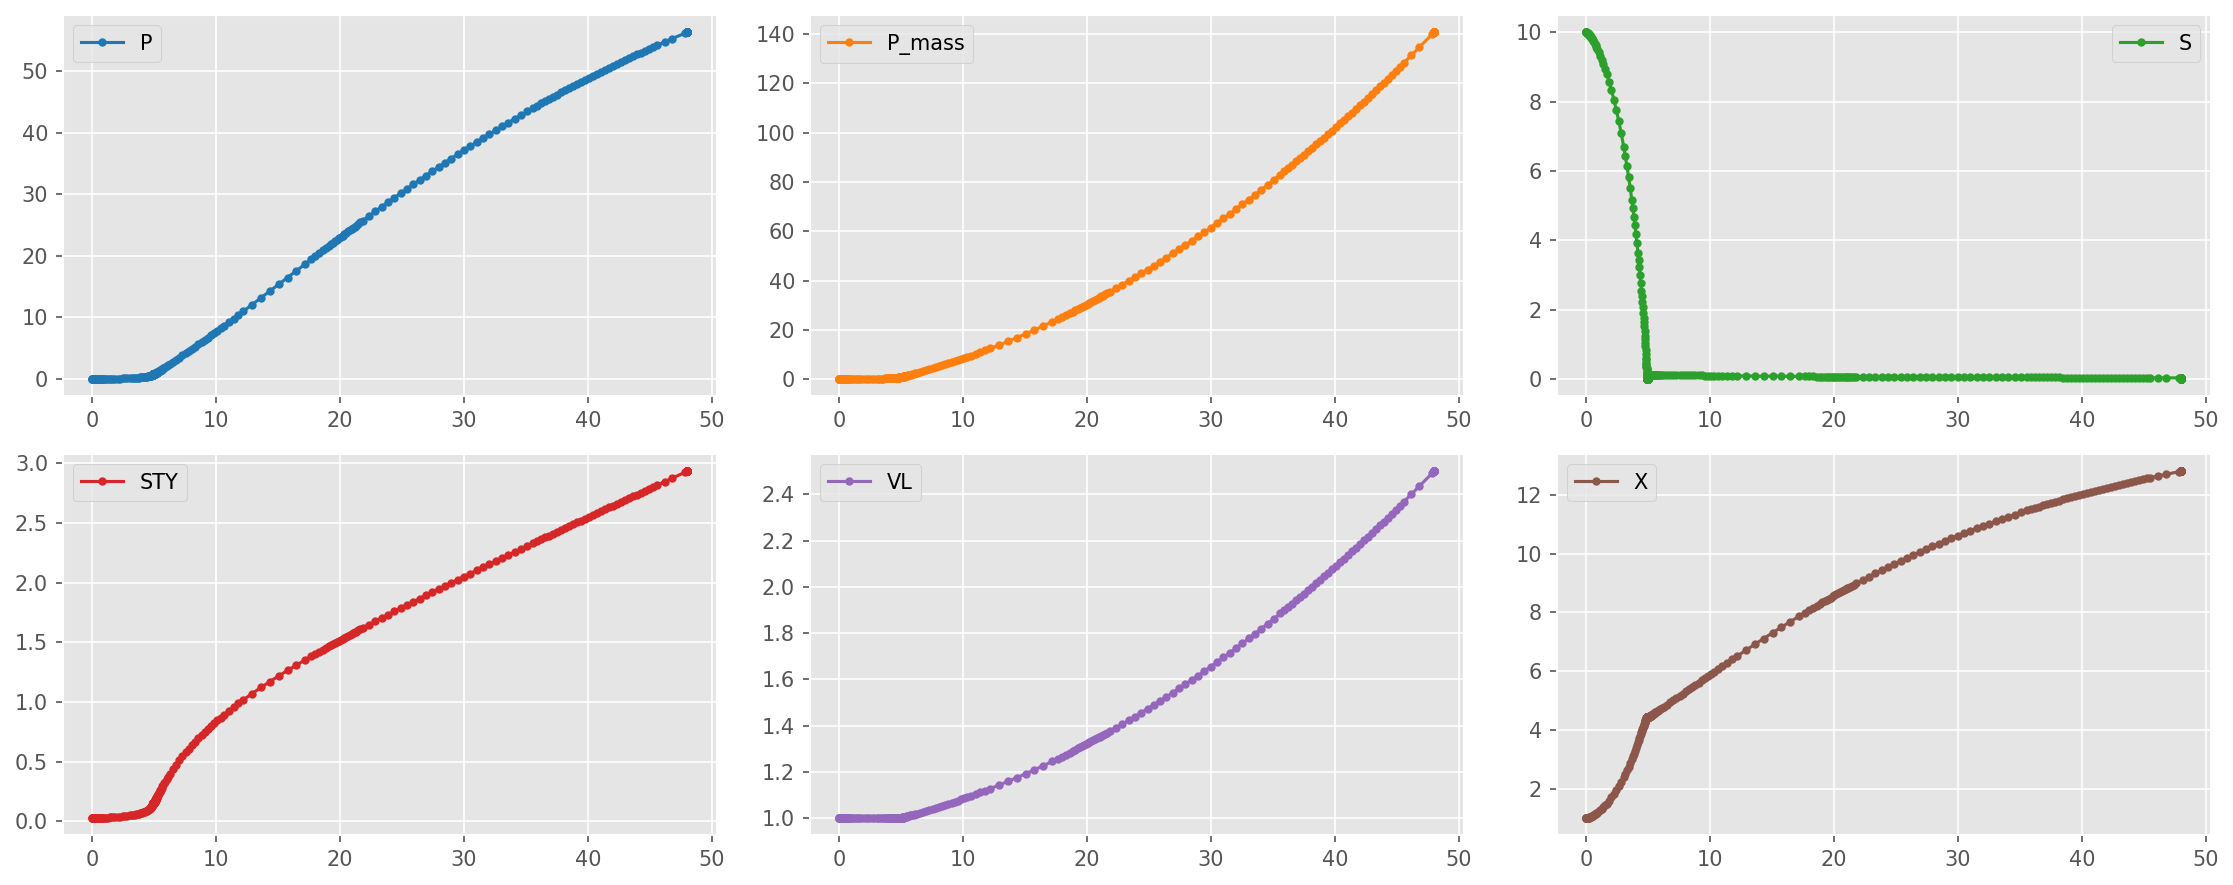

In [31]:
# Show the resulting trajectories
simulation = caretaker.simulate(t=tfinal, parameters=best_estimates)
_, _, additional_timeseries = calculate_additional_timeseries(simulation)
simulation.extend(additional_timeseries)
_ = Visualization.show_kinetic_data(simulation)

### 4.1.2. Maximization of Space-Time-Yield

In [32]:
opt_problem = pygmo.problem(
    OptimizationProblem_PolynomialFeed(
        unknowns=unknowns, 
        bounds=bounds, 
        tfinal=tfinal, 
        caretaker=caretaker, 
        target='STY_max',
    )
)

In [33]:
# Create the islands, each with the same problem, but different algorithms
with io.capture_output() as captured:
    islands = [
        pygmo.island(algo=_algo, prob=opt_problem, size=5*len(unknowns), udi=pygmo.mp_island()) 
        for _algo, _ in zip(algos, range(n_cpus)) # To ensure the number of islands is not greater than the number of cpus
    ]

# Create empty archipelago
archi = pygmo.archipelago(t=pygmo.fully_connected())

# Add the islands to the archipelago
for _island in islands:
    archi.push_back(_island)
archi.wait_check()

In [34]:
evolutions = 15
for i in range(evolutions):
    archi.evolve()
    archi.wait_check()
    best_estimates, best_objective = OptimizationProblem_PolynomialFeed.extract_results(unknowns, archi)
    print(f'Optimal Space-Time-Yield after {i+1} evolutions: {-1*best_objective[0]}')

print('\nOptimal parameter values\n--------------------------')
for _p in best_estimates:
    print(f'{_p} : {best_estimates[_p]}')

Optimal Space-Time-Yield after 1 evolutions: 0.4062746484740234
Optimal Space-Time-Yield after 2 evolutions: 4.816699788776848
Optimal Space-Time-Yield after 3 evolutions: 5.8418854957129245
Optimal Space-Time-Yield after 4 evolutions: 6.387770870143948
Optimal Space-Time-Yield after 5 evolutions: 6.387770870143948
Optimal Space-Time-Yield after 6 evolutions: 6.499149031041925
Optimal Space-Time-Yield after 7 evolutions: 6.5040680160520195
Optimal Space-Time-Yield after 8 evolutions: 6.5040680160520195
Optimal Space-Time-Yield after 9 evolutions: 6.586784010090661
Optimal Space-Time-Yield after 10 evolutions: 6.586784010090661
Optimal Space-Time-Yield after 11 evolutions: 6.586784010090661
Optimal Space-Time-Yield after 12 evolutions: 6.586784010090661
Optimal Space-Time-Yield after 13 evolutions: 6.586784010090661
Optimal Space-Time-Yield after 14 evolutions: 6.586784010090661
Optimal Space-Time-Yield after 15 evolutions: 6.586784010090661

Optimal parameter values
-------------------

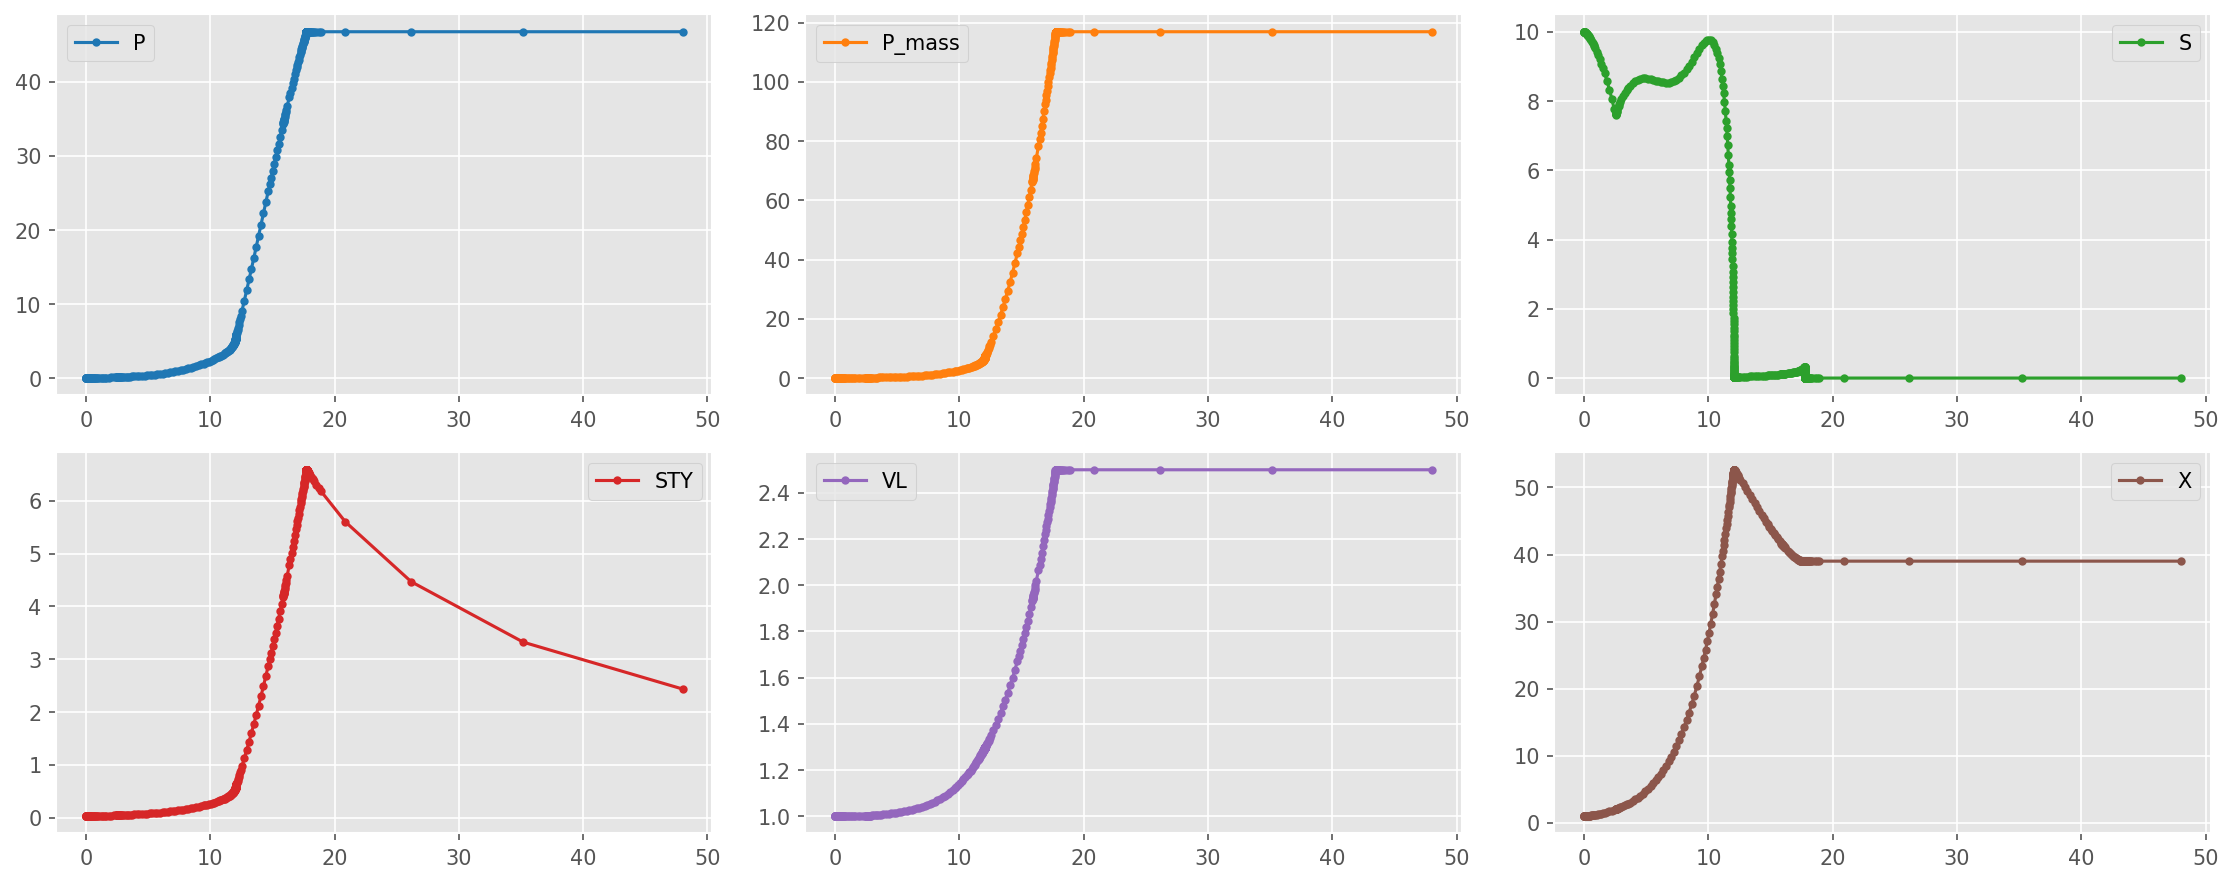

In [35]:
# Show the resulting trajectories
simulation = caretaker.simulate(t=tfinal, parameters=best_estimates)
_, _, additional_timeseries = calculate_additional_timeseries(simulation)
simulation.extend(additional_timeseries)
_ = Visualization.show_kinetic_data(simulation)